In [1]:
import math
import numpy as np
from graphviz import Digraph
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

In [2]:
def graph_attr(root):
    nodes, edges = set(), set()
    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node.childs:
                edges.add((child, node))
                build(child)
    build(root)
    return nodes, edges


def draw_graph(root):
    dig = Digraph(format="svg", graph_attr={"rankdir":"LR"})
    nodes, edges = graph_attr(root)
    for n in nodes:
        uid = str(id(n))
        dig.node(name=uid, label=f"{n.label}|data:{n.data}| grad:{n.grad}", shape="record")
        if n.op:
            dig.node(name=uid+n.op, label=f"{n.op}")
            dig.edge(uid+n.op, uid)
    for n1,n2 in edges:
        dig.edge(str(id(n1)),str(id(n2))+n2.op)
    return dig

In [3]:
class RealValue:
    def __init__(self, data, childs=(), op="", label=""):
        self.data = data
        self.childs = set(childs)
        self.grad = 0
        self.backward= lambda: None
        self.op = op
        self.label = label
    
    def __repr__(self):
        return f"RealValue({self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, RealValue) else RealValue(other, label="const")
        out = RealValue(self.data + other.data, (self, other), "+")
        out.label= "add" if not out.label else out.label
        def backward():
            self.grad  += 1 * out.grad
            other.grad += 1 * out.grad
        out.backward = backward
        
        return out
    def __pow__(self, other):
        assert isinstance(other, float) or isinstance(other, int)
        out =  RealValue(self.data**other, (self,), f'**{other}')
        def backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        out.backward = backward
        return out
    
    def log_10(self):
        out = RealValue(math.log10(self.data), (self,), "log10")
        
        def backward():
            self.grad += ((self.data*2.30)**-1) * out.grad
        out.backward = backward
        return out
    
    def tanh(self):
        out = RealValue(math.tanh(self.data), (self,),"tanh")
        
        def backward():
            self.grad += (1-(out.data)**2) * out.grad
        out.backward = backward
        return out
    
    def relu(self):
        out = RealValue(0 if self.data < 0 else self.data, (self,),"relu")
        
        def backward():
            self.grad += (out.data > 0) * out.grad
        out.backward = backward
        return out
    
    def __mul__(self, other):
            
        other = other if isinstance(other, RealValue) else RealValue(other, label="const")

        out= RealValue(self.data * other.data, (self, other), "*")
        out.label = "mul" if not out.label else out.label
        
        def backward():
            self.grad += other.data * out.grad
            other.grad+= self.data  * out.grad
        out.backward = backward
        return out
    
    def __sub__(self,other):
        return self+(-other)
    
    def __radd__(self, other):
        return self+other
    
    def __rmul__(self, other):
        return self*other 
    
    
    def back_prop(self):
        topo_sort= []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.childs:
                    build_topo(child)
                topo_sort.append(v)
        build_topo(self)
        for node in reversed(topo_sort):
            node.grad=0
        self.grad =1
        for node in reversed(topo_sort):
            node.backward()

In [4]:
x = RealValue(4, label="x")
def forward(x):
    f = x*x + 2*x + 10 ; f.label="f"                  #x*x*x + 2*x*x + 1
    #l = f.tanh(); l.label="l"
    out = f; out.label="o"

    return out
out = forward(x)
out

RealValue(34)

In [5]:
fw= lambda x : x*x + 2*x + 10
x_init = np.arange(-(abs(x.data)+10), abs(x.data)+10, 0.5)
y_init = fw(x_init)

In [6]:
fw(4)

34

In [7]:
x1=[]
y1=[]
x1.append(x.data)
y1.append(out.data)

In [8]:
loss=[]
for i in range(100):
    out.back_prop()
    lr = 0.9   #-0.001*i # learning rate decay
    x.data-= lr * x.grad
    out = forward(x)
    loss.append((x.data,out.data,i))
    if out.data==0:
        break
    #print("loss",out)

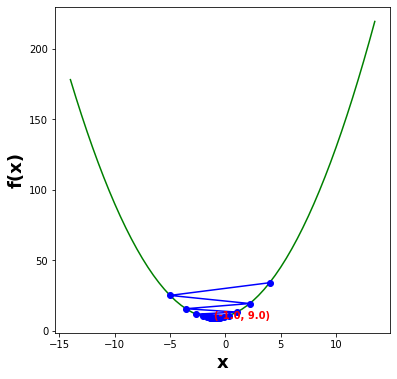

In [9]:
figure, ax = plt.subplots(figsize=(6,6))
for i in loss:
    x1.append(i[0])
    y1.append(i[1])
    ax.cla()
    ax.plot(x_init, y_init, color="green")
    ax.plot(x1, y1, color="blue", marker="o")
    ax.set_xlabel(f"{x.label}",fontdict={"weight":"bold", "fontsize":18})
    ax.set_ylabel(f"f({x.label})",{"weight":"bold","fontsize":18})
    ax.text(x1[-1], y1[-1], f"{(round(x1[-1],2),round(y1[-1],2))}", fontdict={"position": ((x1[-1]), (y1[-1])),"color":"red","weight":"bold"})
    display(figure)    
    clear_output(wait = True)
    plt.pause(0.1)

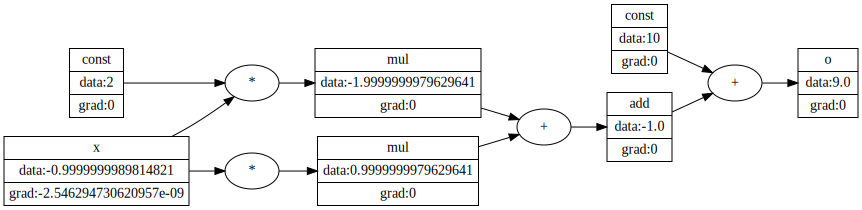

In [10]:
draw_graph(out)

In [11]:
class Neuron:
    def __init__(self, inputs):
        self.rv = np.random.rand(inputs)
        self.weights =  [RealValue(v, label=f"w{i}") for i,v in enumerate(self.rv)]
        self.bias  = RealValue(np.random.rand(1),label=f"b")
        #self.activation = activation
        
    def __call__(self, X):
        #X   = [RealValue(x, label=f"I{i}") for i, x in enumerate(X)]
        out = sum([w*x for w, x in zip(self.weights, X)])
        return out+self.bias
    def param(self):
        return self.weights

In [12]:
class Perceptron:
    def __init__(self, inputs, outputs):
        #self.activation =  activation
        self.weights =  [Neuron(inputs) for _ in range(outputs)]
        
    def __call__(self, X):
        out = [n(X) for n in self.weights]
        return out[0] if len(out)==1 else out
    
    def param(self):
        return [i for w in self.weights for i in w.param()]

In [13]:
class DL:
    def __init__(self, inputs, layers=[2,3,4]):
        all_layers = [inputs]+layers
        self.weights =  [Perceptron(all_layers[i],all_layers[i+1]) for i in range(len(layers))]
        #self.activation=activation
        
    def __call__(self, X):
        for layer in self.weights:
            X = layer(X)
        return X
    
    def param(self):
        return [i for w in self.weights for i in w.param()]

In [14]:
lr=0.01

In [15]:
model=DL(3, [2,1])
out = model([1,2,3])
out = out.relu()
loss = out - 1

In [16]:
loss.back_prop()

In [17]:
for p in model.param():
    print(p.data, p.grad)

0.10137283623849624 [0.28069041]
0.08931217679894143 [0.56138082]
0.803429548499335 [0.84207122]
0.653250069894256 [0.38683772]
0.6528691360810428 [0.77367544]
0.05733294402353184 [1.16051316]
0.28069040795092404 [2.70301729]
0.3868377205683631 [3.03665821]


In [18]:
for p in model.param():
    p.data-= lr * p.grad

In [19]:
model.param()

[RealValue([0.09856593]),
 RealValue([0.08369837]),
 RealValue([0.79500884]),
 RealValue([0.64938169]),
 RealValue([0.64513238]),
 RealValue([0.04572781]),
 RealValue([0.25366024]),
 RealValue([0.35647114])]

In [233]:
#draw_graph(loss)